# Описание задачи

В этом задании необходимо достичь максимального качества предсказания, используя навыки полученные за 4 недели обучения

Кто достигнет максимального значения на тестовой выборке, получит *15 баллов*

Пожалуйста, оформляйте ноутбук аккуратно. Все выводы подписывайте, оформляйте заголовки.

Для справедливой оценки все должны использовать одну и ту же часть исходного датасета в качестве тестового набора данных. Используйте разбиение приведенное ниже


```
train_test_split(X, y, test_size = 0.3, random_state = 69)
```
И модель, с которой вы работаете - это линейная регрессия. Другие алгоритмы не используйте.

Метрика, которую вы должны максимизировать

```
r2_score(y_test, y_pred) и root_mean_squared_error(y_test, y_pred)
```

Целевая переменная - *count*

Обратите внимание на столбцы - 'casual', 'registered'. Эти столбцы в сумме дают целевую переменную, по этой причине их надо удалить. Они линейно зависимы.




Используйтие средства библиотеки sklearn, внимательно изучите ее. Существует огромное количество методов для выполнения каждого из этапов, не бойтесь использовать методы неприведенные в лекции

Этапы, которые необходимо проделать в работе для успешного достижения результата:
* EDA (Исследовать данные, понять с чем имеете дело, наработать идеи для генерации фичей и их обработки, обязательно корреляционные матрицы и графики с hue=классы объектов)
* Анализ выбросов и их обработка (в задачах классификации выброс - это объект с таким признаковым описанием, которое отличается очень сильно от типичного и больше соответствует другому классу)
* Генерация новых фичей
* Обработка пропусков (вы можете сгенерировать новые фичи с пропусками, тогда надо подумать об их обработке)
* Обработка категориальных признаков
* Масштабирование вещественных признаков
* Трансформирование таргета
* Нелинейные автоматические трансформации признаков (Kernel Trick, Transfomers)
* Подбор параметров модели (можете менять не только константы, но и оптимизационные алгоритмы и методы регуляризации)
* Отбор признаков
* Обязательно: Составление пайплайна обучения
* Обязательно: Постройте график зависимости y_pred от y_true в разбиении на test и train. Предсказание идеального алгоритма даст прямую y=x, посмотрите какой график получается у вас.

# Bike Sharing Demand
По историческим данным о прокате велосипедов и погодным условиям необходимо оценить спрос на прокат велосипедов.

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные.

### Библиотеки

### Загрузка данных

***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***casual*** - number of non-registered user rentals initiated

***registered*** - number of registered user rentals initiated

***count*** - number of total rentals

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.compose import TransformedTargetRegressor


In [16]:
# читаем данные
df = pd.read_csv('bike_sharing_demand.csv')
# отделяем тестовую часть 
df = df.drop(['casual', 'registered'], axis=1)
X = df.drop('count', axis=1)
y = df['count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

In [17]:

# Смотрим инфу
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7620 entries, 6867 to 7371
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    7620 non-null   object 
 1   season      7620 non-null   int64  
 2   holiday     7620 non-null   int64  
 3   workingday  7620 non-null   int64  
 4   weather     7620 non-null   int64  
 5   temp        7620 non-null   float64
 6   atemp       7620 non-null   float64
 7   humidity    7620 non-null   int64  
 8   windspeed   7620 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 595.3+ KB


In [18]:
X_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000
mean,2.501837,0.028346,0.682021,1.416273,20.207619,23.615991,61.906562,12.855019
std,1.113990,0.165972,0.465722,0.633698,7.809176,8.495028,19.251588,8.185204
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.998000
75%,3.000000,0.000000,1.000000,2.000000,26.240000,31.060000,77.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900


In [19]:

# Анализ пропусков
X_train.isnull().sum().sum()

0

In [20]:

# Генерация новых признаков
X_train['datetime'] = pd.to_datetime(X_train['datetime'])
X_test['datetime'] = pd.to_datetime(X_test['datetime'])

for dataset in [X_train, X_test]:
    dataset['hour'] = dataset['datetime'].dt.hour
    dataset['day'] = dataset['datetime'].dt.day
    dataset['weekday'] = dataset['datetime'].dt.weekday
    dataset['month'] = dataset['datetime'].dt.month
    dataset['year'] = dataset['datetime'].dt.year

X_train = X_train.drop('datetime', axis=1)
X_test = X_test.drop('datetime', axis=1)

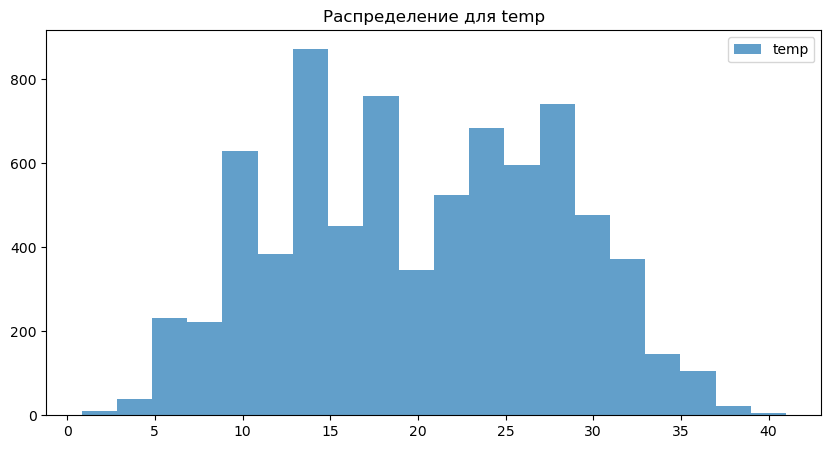

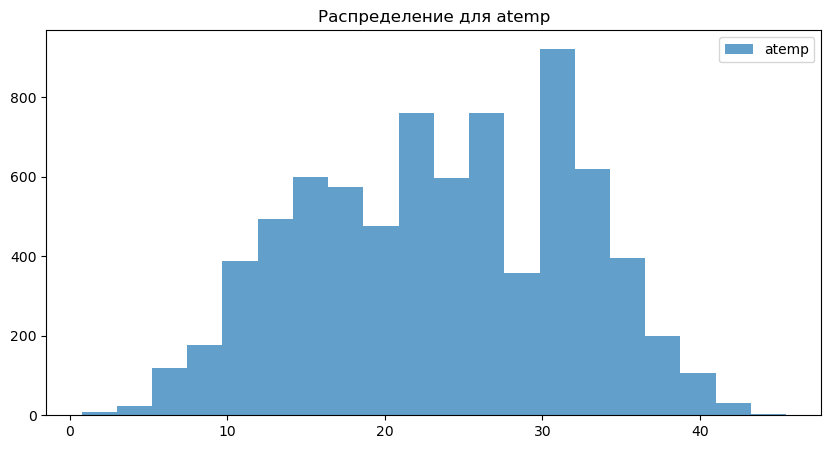

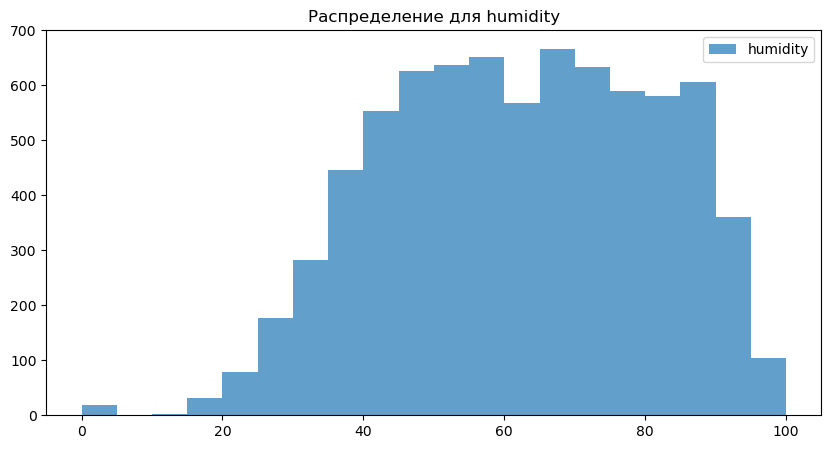

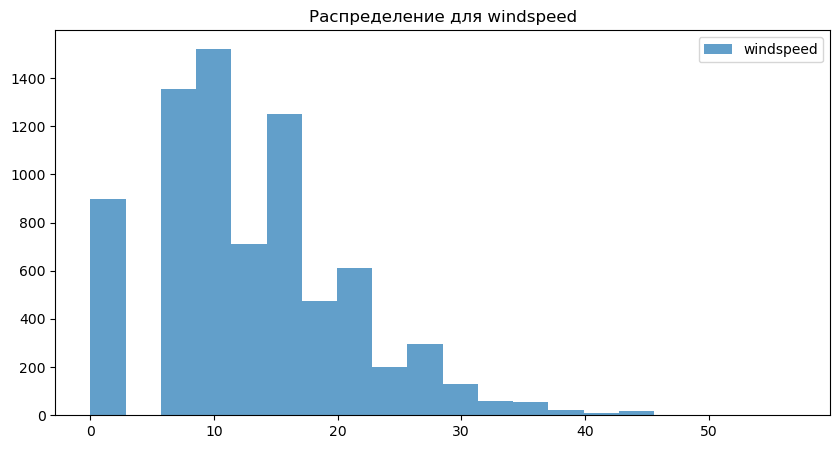

In [21]:

# Проверка выбросов
for feature in ['temp', 'atemp', 'humidity', 'windspeed']:
    plt.figure(figsize=(10, 5))
    plt.hist(X_train[feature], bins=20, alpha=0.7, label=feature)  
    plt.legend()
    plt.title(f"Распределение для {feature}")
    plt.show()

# есть небольшие выбросы, но оставлю их чтобы не терять данные

In [22]:

# делим фичи 
numerical_features = ['temp', 'atemp', 'humidity', 'windspeed']
categorical_features = ['season', 'holiday', 'workingday', 'weather', 'hour', 'weekday', 'month', 'year']

# строим пайплайн для нормализации и добавления полиномиальных фичей
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=6, include_bias=False))
])

# кодируем категориальные признаки
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

In [23]:

# используем регулязиционную модель
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

model = TransformedTargetRegressor(
    regressor=pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

Train R2: 0.7353
Test R2: 0.7306
Train RMSE: 93.1218
Test RMSE: 94.2122


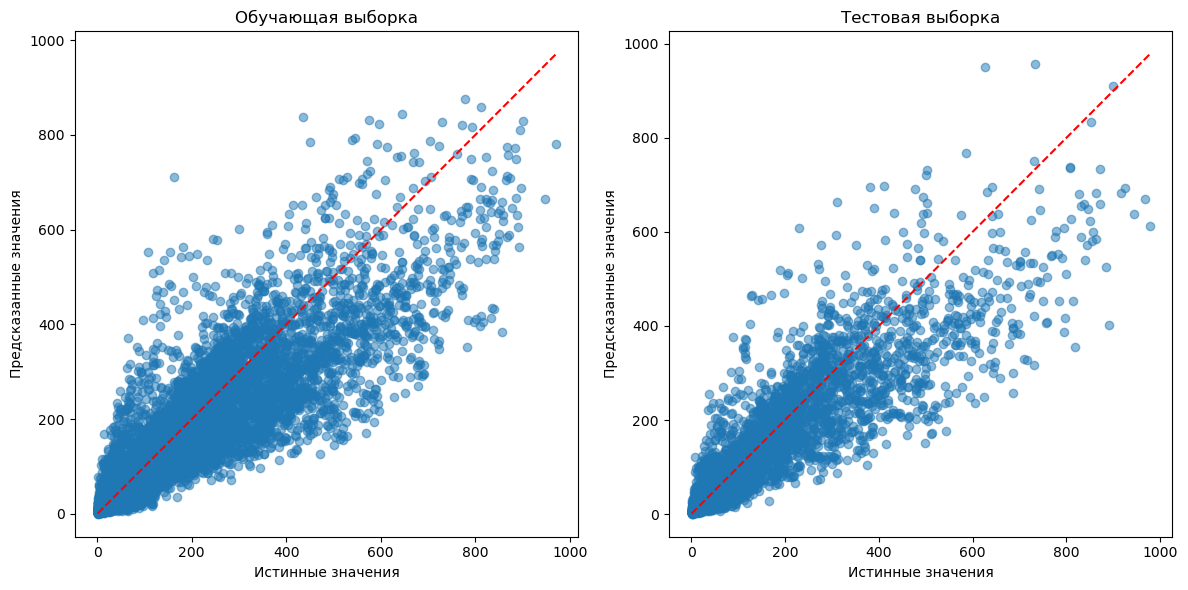

In [24]:

# тренируем модель
param_grid = {
    'regressor__regressor__alpha': np.logspace(-3, 4, 13)
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Оценка модели
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train R2: {train_r2:.4f}")
print(f"Test R2: {test_r2:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Визуализация результатов
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.title("Обучающая выборка")
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Тестовая выборка")
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")

plt.tight_layout()
plt.show()
